In [1]:
from light_curves import LightCurve
from exposures import Calexp
from task import Run

(ra,dec) = (57.67048780800139, -32.49757834967935)/nHTM_ID = 9871863798730 - HTM_level=20 (bounded by a circle of radius ~0.27 arcsec.)
                    Found 150 calexps


/home/karennowo/DP0_microlensing/light_curves.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data], ignore_index=True)


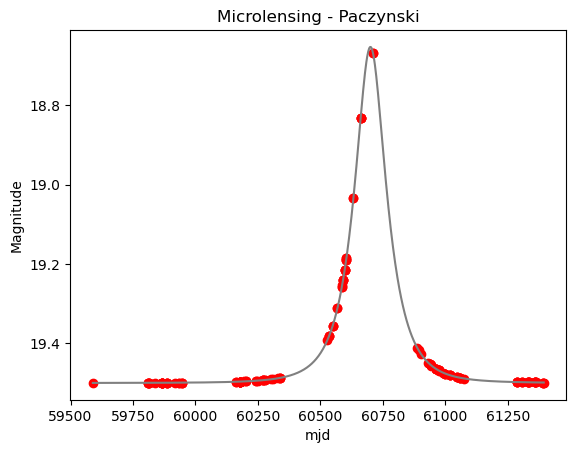

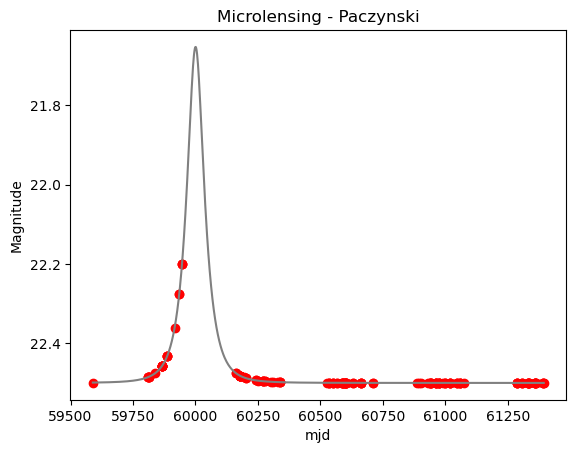

[LightCurve (57.67048780800139, -32.49757834967935) - Band i - Points: 150,
 LightCurve (57.59451632893858, -32.481152201226145) - Band i - Points: 150]

In [2]:
process = Run()
params = [{"t_0": 60700.5, "t_E": 110, "u_0": 0.5, "m_base": 19.5},
          {"t_0": 60000.5, "t_E": 60, "u_0": 0.5, "m_base": 22.5}]
# for p in params:
#     process.add_lc(p, dist=0.2)
process.add_lc(params[0], ra=57.67048780800139, dec=-32.49757834967935, plot=True)
# process.add_lc(params[1], dist=0.2) 
process.add_lc(params[1], ra=57.59451632893858, dec=-32.481152201226145, plot = True)
process.log_task("Add and simulate light curves")
process.inj_lc

In [3]:
process.inject_task()
schema = process.measure_task()
for j, dataId in enumerate(process.calexp_dataIds[:10]):
    print(f" ------ CALEXP {j} ------")
    calexp = Calexp(dataId)
    injected_exp, injected_points = process.inj_calexp(calexp)
    if injected_exp != None:
        sources = process.measure_calexp(injected_exp, schema)
        flux, flux_err = process.find_flux(sources, injected_points, add_to_calexp=dataId)
        for f, ferr, lc in zip(flux, flux_err, process.inj_lc):
            mag, mag_err = lc.add_mag(f, ferr, dataId, exposure = injected_exp)
            print(f"ra = {lc.ra}, dec = {lc.dec}")
            print("Measured ", mag, mag_err)
            print("Injected ", lc.data["mag_sim"][j])


 ------ CALEXP 0 ------
Points injected: 2


[[ 1.00585715 -0.56620598]
 [ 1.00646841 -0.56639938]
 [ 1.00663927 -0.5664524 ]
 ...
 [ 1.00611284 -0.57041025]
 [ 1.00396623 -0.56973046]
 [ 1.00584611 -0.57032593]]
87276.23202454564 558.7965323997907
Founded point in source table in 0 iteration/s
    detector    visit           mjd    mag_sim  flux  flux_err  mag  mag_err
0        117     6855  59589.214718  19.499800   NaN       NaN  NaN      NaN
1        152   174579  59810.371401  19.499526   NaN       NaN  NaN      NaN
2        151   174579  59810.371401  19.499526   NaN       NaN  NaN      NaN
3         65   174586  59810.374548  19.499526   NaN       NaN  NaN      NaN
4         72   177422  59813.364076  19.499520   NaN       NaN  NaN      NaN
..       ...      ...           ...        ...   ...       ...  ...      ...
145      151  1212059  61364.245773  19.498545   NaN       NaN  NaN      NaN
146      102  1229644  61391.061261  19.498747   NaN       NaN  NaN      NaN
147      158  1231296  61393.204087  19.498762   NaN    

[[ 1.00556393 -0.57088648]
 [ 1.00536598 -0.57084986]
 [ 1.00419522 -0.57062595]
 ...
 [ 1.00424663 -0.56668833]
 [ 1.00210186 -0.56629141]
 [ 1.00399989 -0.56664278]]
86958.74164310683 528.5711621585378
Founded point in source table in 0 iteration/s
    detector    visit           mjd    mag_sim          flux    flux_err  \
0        117     6855  59589.214718  19.499800  87276.232025  558.796532   
1        152   174579  59810.371401  19.499526           NaN         NaN   
2        151   174579  59810.371401  19.499526           NaN         NaN   
3         65   174586  59810.374548  19.499526           NaN         NaN   
4         72   177422  59813.364076  19.499520           NaN         NaN   
..       ...      ...           ...        ...           ...         ...   
145      151  1212059  61364.245773  19.498545           NaN         NaN   
146      102  1229644  61391.061261  19.498747           NaN         NaN   
147      158  1231296  61393.204087  19.498762           NaN     

[[ 1.00915819 -0.56995026]
 [ 1.00693124 -0.5696793 ]
 [ 1.00895829 -0.56991982]
 ...
 [ 1.0106868  -0.5662406 ]
 [ 1.00784562 -0.56589207]
 [ 1.00682336 -0.56576526]]
87393.67576456182 528.6250944560754
Founded point in source table in 0 iteration/s
    detector    visit           mjd    mag_sim          flux    flux_err  \
0        117     6855  59589.214718  19.499800  87276.232025  558.796532   
1        152   174579  59810.371401  19.499526  86958.741643  528.571162   
2        151   174579  59810.371401  19.499526           NaN         NaN   
3         65   174586  59810.374548  19.499526           NaN         NaN   
4         72   177422  59813.364076  19.499520           NaN         NaN   
..       ...      ...           ...        ...           ...         ...   
145      151  1212059  61364.245773  19.498545           NaN         NaN   
146      102  1229644  61391.061261  19.498747           NaN         NaN   
147      158  1231296  61393.204087  19.498762           NaN     

[[ 1.0112714  -0.5684669 ]
 [ 1.01105665 -0.56856515]
 [ 1.01074009 -0.56871029]
 ...
 [ 1.00898862 -0.56511651]
 [ 1.00877327 -0.56521341]
 [ 1.0066712  -0.56617231]]
87969.18447871097 508.07678786429506
Founded point in source table in 0 iteration/s
    detector    visit           mjd    mag_sim          flux    flux_err  \
0        117     6855  59589.214718  19.499800  87276.232025  558.796532   
1        152   174579  59810.371401  19.499526  86958.741643  528.571162   
2        151   174579  59810.371401  19.499526           NaN         NaN   
3         65   174586  59810.374548  19.499526  87393.675765  528.625094   
4         72   177422  59813.364076  19.499520           NaN         NaN   
..       ...      ...           ...        ...           ...         ...   
145      151  1212059  61364.245773  19.498545           NaN         NaN   
146      102  1229644  61391.061261  19.498747           NaN         NaN   
147      158  1231296  61393.204087  19.498762           NaN    

[[ 1.01052627 -0.56657466]
 [ 1.00945326 -0.56705463]
 [ 1.00917957 -0.56717655]
 ...
 [ 1.00851129 -0.56310925]
 [ 1.00650032 -0.56400503]
 [ 1.00801388 -0.56333132]]
87437.65958225427 500.0783313080254
Founded point in source table in 0 iteration/s
    detector    visit           mjd    mag_sim          flux    flux_err  \
0        117     6855  59589.214718  19.499800  87276.232025  558.796532   
1        152   174579  59810.371401  19.499526  86958.741643  528.571162   
2        151   174579  59810.371401  19.499526           NaN         NaN   
3         65   174586  59810.374548  19.499526  87393.675765  528.625094   
4         72   177422  59813.364076  19.499520  87969.184479  508.076788   
..       ...      ...           ...        ...           ...         ...   
145      151  1212059  61364.245773  19.498545           NaN         NaN   
146      102  1229644  61391.061261  19.498747           NaN         NaN   
147      158  1231296  61393.204087  19.498762           NaN     

[[ 1.00857568 -0.57052662]
 [ 1.00709819 -0.56952301]
 [ 1.0069889  -0.56944698]
 ...
 [ 1.01097518 -0.56719053]
 [ 1.0104494  -0.56683508]
 [ 1.00907144 -0.56589765]]
87173.27411158348 518.9797869527251
Founded point in source table in 0 iteration/s
    detector    visit           mjd    mag_sim          flux    flux_err  \
0        117     6855  59589.214718  19.499800  87276.232025  558.796532   
1        152   174579  59810.371401  19.499526  86958.741643  528.571162   
2        151   174579  59810.371401  19.499526           NaN         NaN   
3         65   174586  59810.374548  19.499526  87393.675765  528.625094   
4         72   177422  59813.364076  19.499520  87969.184479  508.076788   
..       ...      ...           ...        ...           ...         ...   
145      151  1212059  61364.245773  19.498545           NaN         NaN   
146      102  1229644  61391.061261  19.498747           NaN         NaN   
147      158  1231296  61393.204087  19.498762           NaN     

[[ 1.0044526  -0.56493193]
 [ 1.00480938 -0.56485832]
 [ 1.00490743 -0.5648384 ]
 ...
 [ 1.00950324 -0.56784425]
 [ 1.00592916 -0.56860549]
 [ 1.00614976 -0.56855953]]
88206.24874374094 603.9390368757488
Founded point in source table in 0 iteration/s
    detector    visit           mjd    mag_sim          flux    flux_err  \
0        117     6855  59589.214718  19.499800  87276.232025  558.796532   
1        152   174579  59810.371401  19.499526  86958.741643  528.571162   
2        151   174579  59810.371401  19.499526           NaN         NaN   
3         65   174586  59810.374548  19.499526  87393.675765  528.625094   
4         72   177422  59813.364076  19.499520  87969.184479  508.076788   
..       ...      ...           ...        ...           ...         ...   
145      151  1212059  61364.245773  19.498545           NaN         NaN   
146      102  1229644  61391.061261  19.498747           NaN         NaN   
147      158  1231296  61393.204087  19.498762           NaN     

[[ 1.00538656 -0.56281959]
 [ 1.0062989  -0.5632319 ]
 [ 1.00795402 -0.56398245]
 ...
 [ 1.00341054 -0.56630477]
 [ 1.00452444 -0.56680742]
 [ 1.00617903 -0.56755559]]
86994.57956156394 716.134935223518
Founded point in source table in 0 iteration/s
    detector    visit           mjd    mag_sim          flux    flux_err  \
0        117     6855  59589.214718  19.499800  87276.232025  558.796532   
1        152   174579  59810.371401  19.499526  86958.741643  528.571162   
2        151   174579  59810.371401  19.499526           NaN         NaN   
3         65   174586  59810.374548  19.499526  87393.675765  528.625094   
4         72   177422  59813.364076  19.499520  87969.184479  508.076788   
..       ...      ...           ...        ...           ...         ...   
145      151  1212059  61364.245773  19.498545           NaN         NaN   
146      102  1229644  61391.061261  19.498747           NaN         NaN   
147      158  1231296  61393.204087  19.498762           NaN      

[[ 1.00604246 -0.56458772]
 [ 1.00614325 -0.56463176]
 [ 1.00894972 -0.56585983]
 ...
 [ 1.00530671 -0.56861291]
 [ 1.00458111 -0.56829747]
 [ 1.00612608 -0.56897358]]
86589.18218968417 705.9643912104268
Founded point in source table in 0 iteration/s
    detector    visit           mjd    mag_sim          flux    flux_err  \
0        117     6855  59589.214718  19.499800  87276.232025  558.796532   
1        152   174579  59810.371401  19.499526  86958.741643  528.571162   
2        151   174579  59810.371401  19.499526           NaN         NaN   
3         65   174586  59810.374548  19.499526  87393.675765  528.625094   
4         72   177422  59813.364076  19.499520  87969.184479  508.076788   
..       ...      ...           ...        ...           ...         ...   
145      151  1212059  61364.245773  19.498545           NaN         NaN   
146      102  1229644  61391.061261  19.498747           NaN         NaN   
147      158  1231296  61393.204087  19.498762           NaN     

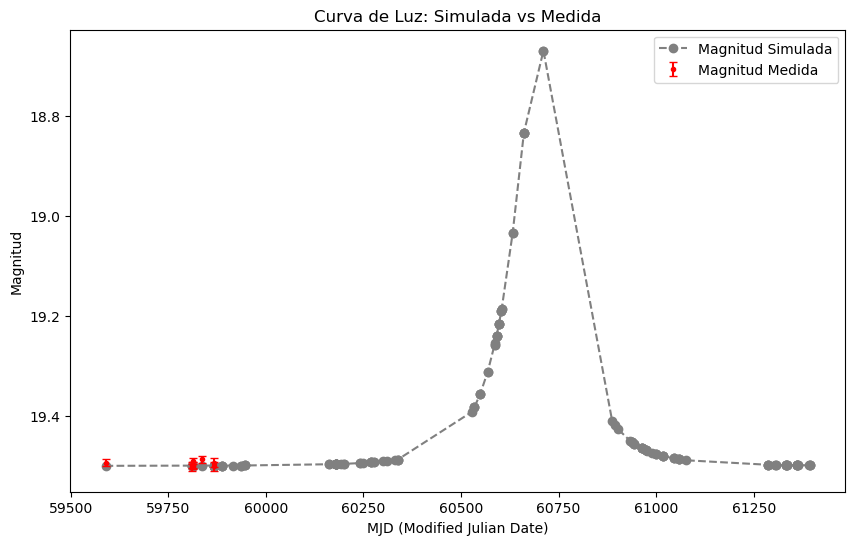

In [8]:
df = self.data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['mjd'], df['mag_sim'], label='Magnitud Simulada', color='gray', linestyle='--', marker='o')
plt.errorbar(df['mjd'], df['mag'], yerr=df['mag_err'], label='Magnitud Medida', color='red', linestyle='', marker='.', capsize=3)
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Magnitud')
plt.x_limit
plt.title(str(self))
plt.gca().invert_yaxis()  
plt.legend()

# Mostrar el gráfico
plt.show()


In [7]:
import numpy as np; search_factor = 100
lc = process.inj_lc[1]
# sources[abs(sources["coord_ra"]-lc.ra*np.pi/180)< 0.0000001*search_factor]["base_PsfFlux_instFlux"]
point = sources[abs(sources["coord_ra"]-lc.ra*np.pi/180)< 0.0000001*search_factor]
print(point["base_PsfFlux_instFlux"], point["base_PsfFlux_instFluxErr"])

[] []


In [4]:
sources[

<class 'lsst.afw.table.SourceRecord'>
id: 2
coord_ra: 1.00647 rad
coord_dec: -0.566399 rad
parent: 0
coord_raErr: 7.04446e-07
coord_decErr: 6.09026e-07
base_SdssCentroid_x: 889.191
base_SdssCentroid_y: 6.82289
base_SdssCentroid_xErr: 0.895927
base_SdssCentroid_yErr: 0.581664
base_SdssCentroid_flag: 1
base_SdssCentroid_flag_edge: 0
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_near_edge: 1
base_SdssCentroid_flag_resetToPeak: 0
base_SdssCentroid_flag_badError: 0
base_Blendedness_old: 0
base_Blendedness_raw: 0
base_Blendedness_raw_child_instFlux: 3725.86
base_Blendedness_raw_parent_instFlux: 3725.86
base_Blendedness_abs: 0
base_Blendedness_abs_child_instFlux: 3813.14
base_Blendedness_abs_parent_instFlux: 3813.14
base_Blendedness_raw_child_xx: 4.2575
base_Blendedness_raw_child_yy: 4.19001
base_Blendedness_raw_child_xy: -0.0345284
base_Blendedness_raw_parent_xx: 4.2575
base_Blende

In [9]:
lc = process.inj_lc[1]
import numpy as np
flux = sources[abs(sources["coord_ra"]-lc.ra*np.pi/180)< 0.0000001]["base_PsfFlux_instFlux"]

flux_err = sources[abs(sources["coord_ra"]-lc.ra*np.pi/180)< 0.0000001]["base_PsfFlux_instFluxErr"]
flux, flux_err

(array([5353.62071767, 1748.9515086 ]), array([], dtype=float64))

In [12]:
sources[abs(sources["coord_ra"]-lc.dec*np.pi/180)< 0.000001]["base_PsfFlux_instFluxErr"]

array([], dtype=float64)

In [31]:
photoCalib = calexp.getPhotoCalib()
measure = photoCalib.instFluxToMagnitude(flux, flux_err)
measure

TypeError: instFluxToMagnitude(): incompatible function arguments. The following argument types are supported:
    1. (self: lsst.afw.image.PhotoCalib, instFlux: float, point: lsst.geom.Point2D) -> float
    2. (self: lsst.afw.image.PhotoCalib, instFlux: float) -> float
    3. (self: lsst.afw.image.PhotoCalib, instFlux: float, instFluxErr: float, point: lsst.geom.Point2D) -> lsst.afw.image.Measurement
    4. (self: lsst.afw.image.PhotoCalib, instFlux: float, instFluxErr: float) -> lsst.afw.image.Measurement
    5. (self: lsst.afw.image.PhotoCalib, sourceRecord: lsst.afw.table.SourceRecord, instFluxField: str) -> lsst.afw.image.Measurement
    6. (self: lsst.afw.image.PhotoCalib, sourceCatalog: lsst.afw.table.SourceCatalog, instFluxField: str) -> numpy.ndarray
    7. (self: lsst.afw.image.PhotoCalib, sourceCatalog: lsst.afw.table.SourceCatalog, instFluxField: str, outField: str) -> None

Invoked with: PhotoCalib(spatially constant with mean: 0.663395 error: 0.000191301), array([  2461.71788019,   4045.1511727 ,  86621.49341173,   1555.3560409 ,
       190471.87429229,   1590.17693678,   1742.61653024,   2485.66688496,
         1533.09955738,   2024.36485124,   1645.20600364]), array([364.87366365, 368.92062597, 557.12496064, 361.54029925,
       730.17100428, 362.0646844 , 362.38617075, 363.94345942,
       361.54666045, 364.79217286, 361.77673602])